In [1]:
import sys
from comet_ml import Experiment
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary

# Local imports
sys.path.append("/Users/leo/Programming/Thesis/utils")
sys.path.append("/Users/leo/Programming/Thesis/models")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from GhostNetCBAM import ghost_net
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": "ghost",
    "module_alias": "GhostNet",
    "data_path": "/Users/leo/Programming/Thesis/data/vgg_200/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 200,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = ghost_net(num_classes=prms["num_classes"], module_type = prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/vgg-200/ea46d6dfa038446ea2f9a6497ef7d145



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


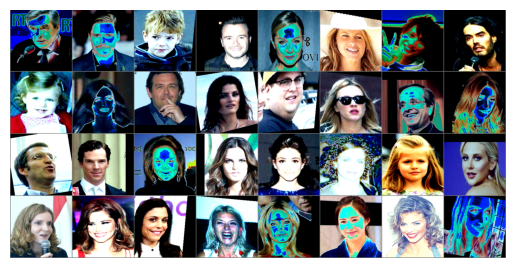

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = prms["model"].to(prms["device"])

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
GhostNetCBAM (GhostNetCBAM)                                  [1, 3, 224, 224]     [1, 200]             --                   --                   --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 96, 7, 7]        --                   --                   --                   True
│    └─Sequential (0)                                        [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --              

100%|██████████| 343/343 [00:33<00:00, 10.24it/s]


Epoch: 01 | Epoch Time: 12.0m 37s
	Train Loss: 4.809 | Train Acc: 3.79%
	 Val. Loss: 4.162 |  Val. Acc: 8.46%
Best Accuracy Achieved: 8.46% on epoch 01


100%|██████████| 343/343 [00:34<00:00, 10.02it/s]


Epoch: 02 | Epoch Time: 12.0m 20s
	Train Loss: 3.961 | Train Acc: 11.74%
	 Val. Loss: 3.391 |  Val. Acc: 20.24%
Best Accuracy Achieved: 20.24% on epoch 02


100%|██████████| 343/343 [00:33<00:00, 10.12it/s]


Epoch: 03 | Epoch Time: 12.0m 25s
	Train Loss: 3.245 | Train Acc: 23.50%
	 Val. Loss: 2.703 |  Val. Acc: 33.84%
Best Accuracy Achieved: 33.84% on epoch 03


100%|██████████| 343/343 [00:35<00:00,  9.80it/s]


Epoch: 04 | Epoch Time: 12.0m 22s
	Train Loss: 2.709 | Train Acc: 33.89%
	 Val. Loss: 2.255 |  Val. Acc: 43.51%
Best Accuracy Achieved: 43.51% on epoch 04


100%|██████████| 343/343 [00:35<00:00,  9.58it/s]


Epoch: 05 | Epoch Time: 12.0m 36s
	Train Loss: 2.308 | Train Acc: 42.45%
	 Val. Loss: 2.042 |  Val. Acc: 49.20%
Best Accuracy Achieved: 49.20% on epoch 05


100%|██████████| 343/343 [00:35<00:00,  9.77it/s]


Epoch: 06 | Epoch Time: 12.0m 30s
	Train Loss: 2.019 | Train Acc: 48.87%
	 Val. Loss: 1.765 |  Val. Acc: 55.16%
Best Accuracy Achieved: 55.16% on epoch 06


100%|██████████| 343/343 [00:33<00:00, 10.14it/s]


Epoch: 07 | Epoch Time: 12.0m 14s
	Train Loss: 1.793 | Train Acc: 54.05%
	 Val. Loss: 1.595 |  Val. Acc: 59.58%
Best Accuracy Achieved: 59.58% on epoch 07


100%|██████████| 343/343 [00:33<00:00, 10.12it/s]


Epoch: 08 | Epoch Time: 12.0m 17s
	Train Loss: 1.619 | Train Acc: 57.82%
	 Val. Loss: 1.489 |  Val. Acc: 61.66%
Best Accuracy Achieved: 61.66% on epoch 08


100%|██████████| 343/343 [00:35<00:00,  9.75it/s]


Epoch: 09 | Epoch Time: 12.0m 17s
	Train Loss: 1.455 | Train Acc: 61.66%
	 Val. Loss: 1.482 |  Val. Acc: 63.03%
Best Accuracy Achieved: 63.03% on epoch 09


100%|██████████| 343/343 [00:34<00:00,  9.96it/s]


Epoch: 10 | Epoch Time: 12.0m 2s
	Train Loss: 1.325 | Train Acc: 64.88%
	 Val. Loss: 1.364 |  Val. Acc: 65.68%
Best Accuracy Achieved: 65.68% on epoch 10


100%|██████████| 343/343 [00:34<00:00, 10.02it/s]


Epoch: 11 | Epoch Time: 12.0m 20s
	Train Loss: 1.212 | Train Acc: 67.29%
	 Val. Loss: 1.371 |  Val. Acc: 65.35%


100%|██████████| 343/343 [00:32<00:00, 10.50it/s]


Epoch: 12 | Epoch Time: 12.0m 3s
	Train Loss: 1.120 | Train Acc: 69.62%
	 Val. Loss: 1.225 |  Val. Acc: 69.10%
Best Accuracy Achieved: 69.10% on epoch 12


100%|██████████| 343/343 [00:33<00:00, 10.39it/s]


Epoch: 13 | Epoch Time: 12.0m 0s
	Train Loss: 1.033 | Train Acc: 71.88%
	 Val. Loss: 1.231 |  Val. Acc: 69.29%
Best Accuracy Achieved: 69.29% on epoch 13


100%|██████████| 343/343 [00:31<00:00, 10.74it/s]


Epoch: 14 | Epoch Time: 11.0m 53s
	Train Loss: 0.955 | Train Acc: 73.69%
	 Val. Loss: 1.290 |  Val. Acc: 68.79%


100%|██████████| 343/343 [00:33<00:00, 10.27it/s]


Epoch: 15 | Epoch Time: 12.0m 2s
	Train Loss: 0.896 | Train Acc: 75.22%
	 Val. Loss: 1.154 |  Val. Acc: 71.73%
Best Accuracy Achieved: 71.73% on epoch 15


100%|██████████| 343/343 [00:33<00:00, 10.32it/s]


Epoch: 16 | Epoch Time: 12.0m 2s
	Train Loss: 0.839 | Train Acc: 76.57%
	 Val. Loss: 1.192 |  Val. Acc: 70.60%


100%|██████████| 343/343 [00:33<00:00, 10.35it/s]


Epoch: 17 | Epoch Time: 11.0m 59s
	Train Loss: 0.789 | Train Acc: 77.91%
	 Val. Loss: 1.146 |  Val. Acc: 72.51%
Best Accuracy Achieved: 72.51% on epoch 17


100%|██████████| 343/343 [00:31<00:00, 10.83it/s]


Epoch: 18 | Epoch Time: 11.0m 53s
	Train Loss: 0.735 | Train Acc: 79.38%
	 Val. Loss: 1.124 |  Val. Acc: 73.01%
Best Accuracy Achieved: 73.01% on epoch 18


100%|██████████| 343/343 [00:31<00:00, 10.76it/s]


Epoch: 19 | Epoch Time: 11.0m 24s
	Train Loss: 0.697 | Train Acc: 80.13%
	 Val. Loss: 1.225 |  Val. Acc: 72.12%


100%|██████████| 343/343 [00:34<00:00,  9.92it/s]


Epoch: 20 | Epoch Time: 11.0m 53s
	Train Loss: 0.669 | Train Acc: 80.97%
	 Val. Loss: 1.173 |  Val. Acc: 72.85%


100%|██████████| 343/343 [00:34<00:00,  9.95it/s]


Epoch: 21 | Epoch Time: 12.0m 5s
	Train Loss: 0.626 | Train Acc: 81.95%
	 Val. Loss: 1.164 |  Val. Acc: 73.57%
Best Accuracy Achieved: 73.57% on epoch 21


100%|██████████| 343/343 [00:34<00:00,  9.92it/s]


Epoch: 22 | Epoch Time: 12.0m 7s
	Train Loss: 0.594 | Train Acc: 82.82%
	 Val. Loss: 1.096 |  Val. Acc: 74.11%
Best Accuracy Achieved: 74.11% on epoch 22


100%|██████████| 343/343 [00:32<00:00, 10.45it/s]


Epoch: 23 | Epoch Time: 12.0m 2s
	Train Loss: 0.557 | Train Acc: 83.83%
	 Val. Loss: 1.092 |  Val. Acc: 74.63%
Best Accuracy Achieved: 74.63% on epoch 23


100%|██████████| 343/343 [00:32<00:00, 10.59it/s]


Epoch: 24 | Epoch Time: 11.0m 57s
	Train Loss: 0.543 | Train Acc: 84.23%
	 Val. Loss: 1.096 |  Val. Acc: 75.57%
Best Accuracy Achieved: 75.57% on epoch 24


100%|██████████| 343/343 [00:33<00:00, 10.12it/s]


Epoch: 25 | Epoch Time: 11.0m 58s
	Train Loss: 0.524 | Train Acc: 84.59%
	 Val. Loss: 1.039 |  Val. Acc: 76.19%
Best Accuracy Achieved: 76.19% on epoch 25


100%|██████████| 343/343 [00:32<00:00, 10.63it/s]


Epoch: 26 | Epoch Time: 12.0m 2s
	Train Loss: 0.491 | Train Acc: 85.55%
	 Val. Loss: 1.093 |  Val. Acc: 75.68%


100%|██████████| 343/343 [00:33<00:00, 10.29it/s]


Epoch: 27 | Epoch Time: 12.0m 3s
	Train Loss: 0.470 | Train Acc: 86.14%
	 Val. Loss: 1.164 |  Val. Acc: 75.28%


100%|██████████| 343/343 [00:30<00:00, 11.10it/s]


Epoch: 28 | Epoch Time: 12.0m 1s
	Train Loss: 0.459 | Train Acc: 86.46%
	 Val. Loss: 1.080 |  Val. Acc: 76.14%


100%|██████████| 343/343 [00:51<00:00,  6.70it/s]


Epoch: 29 | Epoch Time: 12.0m 41s
	Train Loss: 0.436 | Train Acc: 87.11%
	 Val. Loss: 1.126 |  Val. Acc: 76.51%
Best Accuracy Achieved: 76.51% on epoch 29


100%|██████████| 343/343 [00:33<00:00, 10.15it/s]


Epoch: 30 | Epoch Time: 13.0m 31s
	Train Loss: 0.416 | Train Acc: 87.85%
	 Val. Loss: 1.080 |  Val. Acc: 77.35%
Best Accuracy Achieved: 77.35% on epoch 30


100%|██████████| 343/343 [00:34<00:00,  9.87it/s]


Epoch: 31 | Epoch Time: 12.0m 38s
	Train Loss: 0.424 | Train Acc: 87.59%
	 Val. Loss: 1.039 |  Val. Acc: 77.46%
Best Accuracy Achieved: 77.46% on epoch 31


100%|██████████| 343/343 [00:33<00:00, 10.38it/s]


Epoch: 32 | Epoch Time: 12.0m 2s
	Train Loss: 0.381 | Train Acc: 88.65%
	 Val. Loss: 1.050 |  Val. Acc: 77.18%


100%|██████████| 343/343 [00:32<00:00, 10.61it/s]


Epoch: 33 | Epoch Time: 11.0m 39s
	Train Loss: 0.378 | Train Acc: 88.64%
	 Val. Loss: 1.118 |  Val. Acc: 76.47%


100%|██████████| 343/343 [00:32<00:00, 10.45it/s]


Epoch: 34 | Epoch Time: 11.0m 54s
	Train Loss: 0.365 | Train Acc: 89.20%
	 Val. Loss: 1.094 |  Val. Acc: 77.21%


100%|██████████| 343/343 [00:34<00:00,  9.98it/s]


Epoch: 35 | Epoch Time: 12.0m 6s
	Train Loss: 0.350 | Train Acc: 89.51%
	 Val. Loss: 1.157 |  Val. Acc: 76.44%


100%|██████████| 343/343 [00:35<00:00,  9.53it/s]


Epoch: 36 | Epoch Time: 14.0m 3s
	Train Loss: 0.352 | Train Acc: 89.62%
	 Val. Loss: 1.152 |  Val. Acc: 76.73%


100%|██████████| 343/343 [00:33<00:00, 10.31it/s]


Epoch 00037: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 37 | Epoch Time: 12.0m 0s
	Train Loss: 0.332 | Train Acc: 90.07%
	 Val. Loss: 1.119 |  Val. Acc: 77.56%
Best Accuracy Achieved: 77.56% on epoch 37


100%|██████████| 343/343 [00:33<00:00, 10.39it/s]


Epoch: 38 | Epoch Time: 11.0m 58s
	Train Loss: 0.146 | Train Acc: 95.73%
	 Val. Loss: 0.989 |  Val. Acc: 81.55%
Best Accuracy Achieved: 81.55% on epoch 38


100%|██████████| 343/343 [00:34<00:00, 10.05it/s]


Epoch: 39 | Epoch Time: 12.0m 1s
	Train Loss: 0.112 | Train Acc: 96.81%
	 Val. Loss: 1.005 |  Val. Acc: 82.11%
Best Accuracy Achieved: 82.11% on epoch 39


100%|██████████| 343/343 [00:33<00:00, 10.31it/s]


Epoch: 40 | Epoch Time: 12.0m 0s
	Train Loss: 0.099 | Train Acc: 97.18%
	 Val. Loss: 1.039 |  Val. Acc: 82.17%
Best Accuracy Achieved: 82.17% on epoch 40


100%|██████████| 343/343 [00:32<00:00, 10.47it/s]


Epoch: 41 | Epoch Time: 12.0m 2s
	Train Loss: 0.096 | Train Acc: 97.32%
	 Val. Loss: 1.087 |  Val. Acc: 81.90%


100%|██████████| 343/343 [00:46<00:00,  7.44it/s]


Epoch: 42 | Epoch Time: 13.0m 47s
	Train Loss: 0.087 | Train Acc: 97.52%
	 Val. Loss: 1.028 |  Val. Acc: 82.58%
Best Accuracy Achieved: 82.58% on epoch 42


100%|██████████| 343/343 [00:35<00:00,  9.58it/s]


Epoch: 43 | Epoch Time: 13.0m 18s
	Train Loss: 0.083 | Train Acc: 97.64%
	 Val. Loss: 1.064 |  Val. Acc: 82.47%


100%|██████████| 343/343 [00:35<00:00,  9.53it/s]


Epoch 00044: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 44 | Epoch Time: 13.0m 7s
	Train Loss: 0.079 | Train Acc: 97.74%
	 Val. Loss: 1.082 |  Val. Acc: 82.18%


100%|██████████| 343/343 [00:32<00:00, 10.64it/s]


Epoch: 45 | Epoch Time: 12.0m 25s
	Train Loss: 0.071 | Train Acc: 97.98%
	 Val. Loss: 1.061 |  Val. Acc: 82.52%


100%|██████████| 343/343 [00:32<00:00, 10.62it/s]


Epoch: 46 | Epoch Time: 11.0m 35s
	Train Loss: 0.067 | Train Acc: 98.15%
	 Val. Loss: 1.059 |  Val. Acc: 82.59%
Best Accuracy Achieved: 82.59% on epoch 46


100%|██████████| 343/343 [00:30<00:00, 11.29it/s]


Epoch: 47 | Epoch Time: 11.0m 23s
	Train Loss: 0.066 | Train Acc: 98.17%
	 Val. Loss: 1.055 |  Val. Acc: 82.77%
Best Accuracy Achieved: 82.77% on epoch 47


100%|██████████| 343/343 [00:40<00:00,  8.37it/s]


Epoch: 48 | Epoch Time: 27.0m 36s
	Train Loss: 0.066 | Train Acc: 98.16%
	 Val. Loss: 1.053 |  Val. Acc: 82.51%


100%|██████████| 343/343 [00:42<00:00,  8.06it/s]


Epoch: 49 | Epoch Time: 18.0m 25s
	Train Loss: 0.063 | Train Acc: 98.23%
	 Val. Loss: 1.057 |  Val. Acc: 82.80%
Best Accuracy Achieved: 82.80% on epoch 49


100%|██████████| 343/343 [00:43<00:00,  7.81it/s]


Epoch 00050: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 50 | Epoch Time: 17.0m 51s
	Train Loss: 0.065 | Train Acc: 98.22%
	 Val. Loss: 1.056 |  Val. Acc: 82.74%


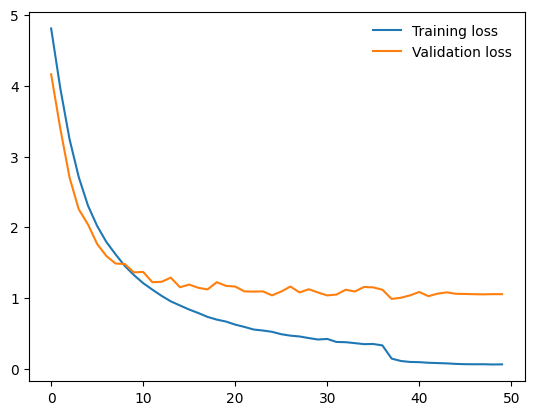

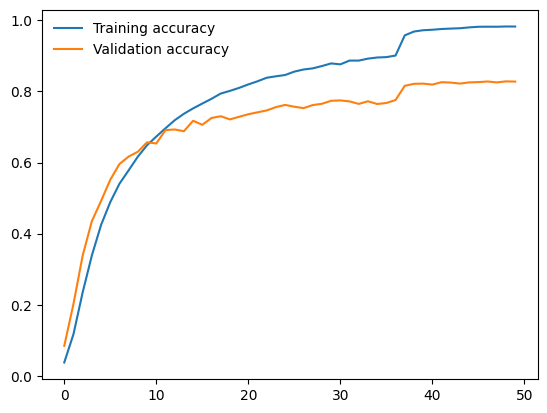

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [9]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/vgg-200/ea46d6dfa038446ea2f9a6497ef7d145
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     flops           : 46156198.0
COMET INFO:     inference_time  : 0.004150091224735202
COMET INFO:     loss [13595]    : (-36.02558135986328, 6.473406791687012)
COMET INFO:     params          : 1379546.0
COMET INFO:     test_accuracy   : 0.8218427300453186
COMET INFO:     test_loss       : 1.119559431311232
COMET INFO:     train_acc [50]  : (0.0379134900867939, 0.9823355078697205)
COMET INFO:     train_loss [50] : (0.06299925971619803, 4.8086225758353045)
COMET INFO:     val_acc [50]    : (0.08461116999387741, 0.82

Test loss: 1.120.. 
Test accuracy: 0.822
Test Time: 0.0m 45s 447ms


─────────────────────────────────────────────── New Comet feature! ───────────────────────────────────────────────
Log your models to better track, deploy, share, and reproduce your work using: 'comet_ml.integration.pytorch.log_model'.
Learn more at: https://comet.com/docs/v2/pytorch_log_model

Hide this message by setting environment variable "COMET_DISABLE_ANNOUNCEMENT=1" 
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)


(1.119559431311232, tensor(0.8218, device='mps:0'))